In [12]:
# tools: reducing the number of nets to one
import numpy as np

def simplify_board(filename):
    board = np.loadtxt(filename, delimiter=',')
    for i in range(board.shape[0]):
        for j in range(board.shape[1]):
            if abs(board[i,j])>=2 and abs(board[i,j])!=8:
                board[i,j] = 1
    np.savetxt("sim_board.csv", board, delimiter=',')
    return board
board = simplify_board("testboard.csv")
print(np.amin(board))

-8.0


In [21]:
# test gossiping routing
import numpy as np
import random
from copy import copy

def cos_value(B, A, D):
    '''
    B, A, D should be numpy arrays
    return cos(BAD)
    '''
    AB_vec = B-A
    AD_vec = D-A
    dot_product = np.dot(AB_vec, AD_vec)
    AB = np.linalg.norm(AB_vec)
    AD = np.linalg.norm(AD_vec)
    return dot_product/(AB*AD)

def Score1(B, A, D):
    return cos_value(B,A,D)

def Score2(B,A,D):
    return 1 + cos_value(B,A,D)

def Score3(B,A,D,e):
    # e = 0.3
    return (1-e)/(1-e*cos_value(B,A,D))

def find_node(board, number):
    '''
    return a numpy array with 2 elements
    '''
    return np.asarray(np.where(board == number)).reshape(-1)

def connect(board, net_number, e):
    boards = np.array([copy(board)])
#     current_node = find_node(board)
    paths = [[]]
    final_paths = []
    max_iters = board.shape[0]+board.shape[1]
    for j in range(max_iters):
    # while len(final_paths)<2:
        boards_tem = []
        paths_tem = []
        for i in range(len(boards)):
            b = boards[i]
            p = paths[i]
            bs_tem, ps_tem, path = take_actions(b,p, net_number, e)
            if path is not None:
                final_paths.append(path)
            boards_tem += bs_tem
            paths_tem += ps_tem
        if len(boards_tem)>200:
            random_index = random.sample(range(1, len(boards_tem)), 200)
            boards = np.array(boards_tem)[random_index]
            paths = [paths_tem[i] for i in random_index]
        else:
            boards = np.array(boards_tem)
            paths = paths_tem

        if len(final_paths)>=50:
            break

    return final_paths

def take_actions(board, path, net_number, e):
    '''
    return a list of 2d numpy array (board)
    '''
    # net_number = 2
    boards_next = []
    paths_next = []
    current_node = find_node(board, net_number)
    # print(net_number)
    neighbors = find_neighbors(board, current_node, net_number)
    
    if len(neighbors)==0:
        return [], [], None
    
    destination = find_node(board, -net_number)
    probs = calculate_probs(neighbors, current_node, destination, e)
    
    if tuple(destination) in neighbors:
        return boards_next, paths_next, path
        
    for neighbor in neighbors:
        prob = probs[neighbor]
        if random.random()<=prob:
            board_next = copy(board)
            path_next = copy(path)
            board_next[neighbor] = net_number
            board_next[tuple(current_node)] = 1
            path_next.append(neighbor)
            boards_next.append(board_next)
            paths_next.append(path_next)
            
    return boards_next, paths_next, None

def find_neighbors(board, current_node, net_number):
    '''
    current_node is a numpy array
    return:
    neighbors a list of tuples
    '''
    # print("--------------")
    neighbors = []
    directions = np.array([[0,1], [0,-1], [1,0], [-1,0]])
    for d in directions:
        # print(current_node)
        candidate_neighbor = tuple(current_node + d)
        if np.amax(candidate_neighbor)<board.shape[0] and np.amin(candidate_neighbor)>=0:
            if board[candidate_neighbor]==0 or board[candidate_neighbor]==-net_number:
                neighbors.append(candidate_neighbor)
    return neighbors

def calculate_probs(neighbors, current_node, destination, e):
    '''
    return a dict mapping the tuple-based neighbors to probs 
    '''
    probs = dict()
    for neighbor in neighbors:
        probs[neighbor] = Score3(np.asarray(neighbor), current_node, destination, e)
        
    max_score = max(probs.values())
    for neighbor in neighbors:
        probs[neighbor] /= max_score
    return probs

board = np.loadtxt("sim_board.csv", delimiter=',')
routes = connect(board, 8, 0.9)
# [print(len(r)) for r in routes]


/home/youbiao/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


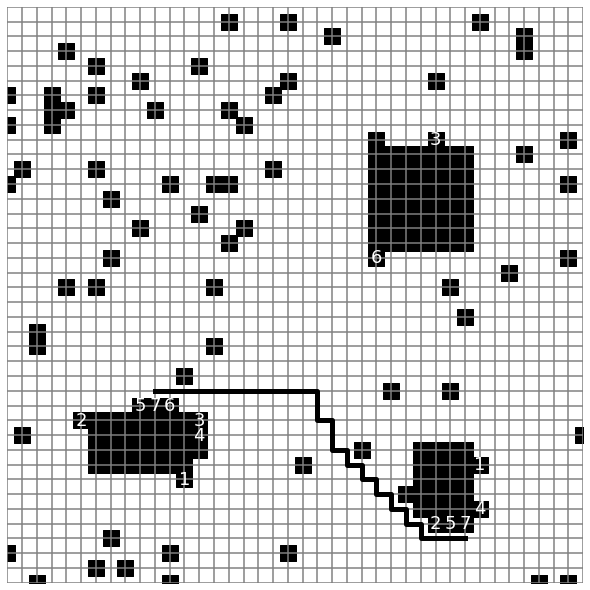

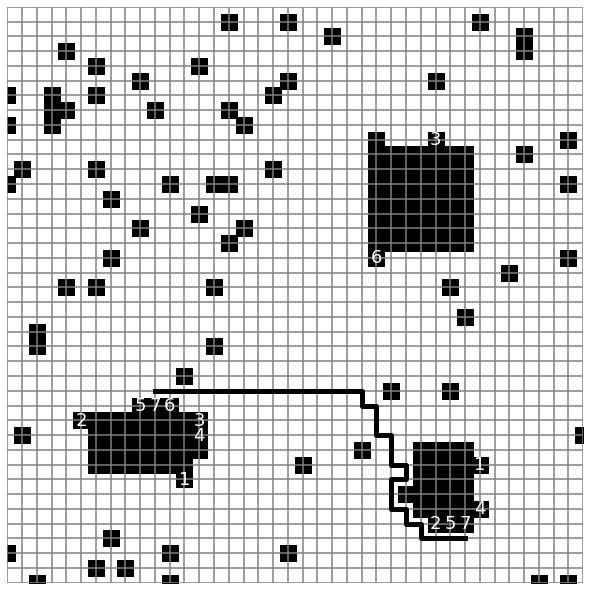

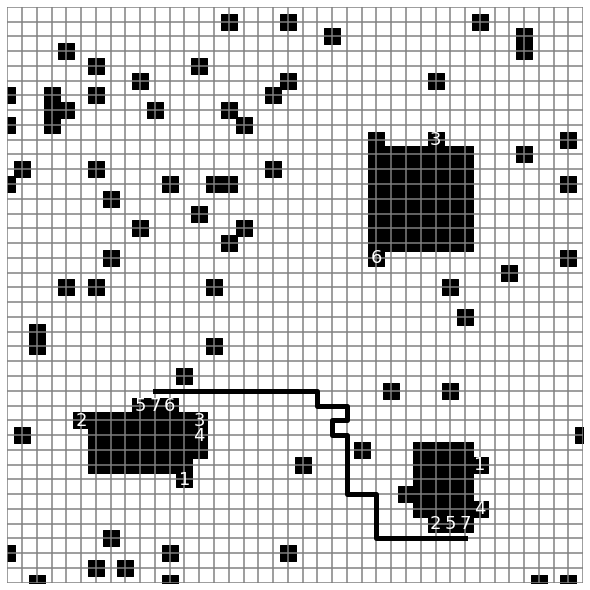

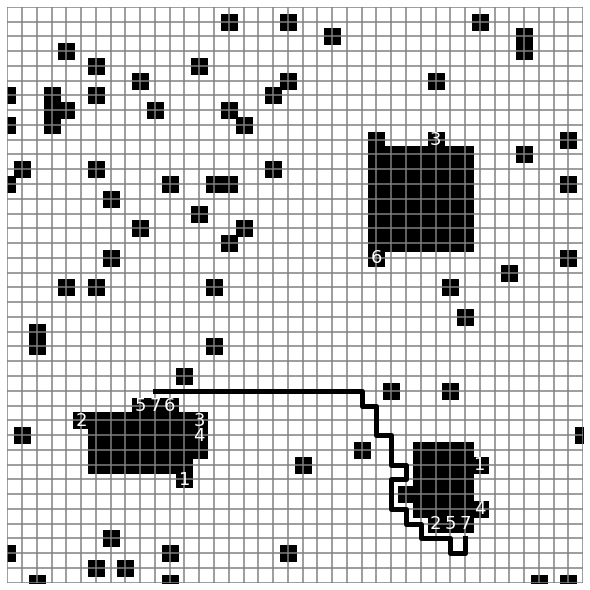

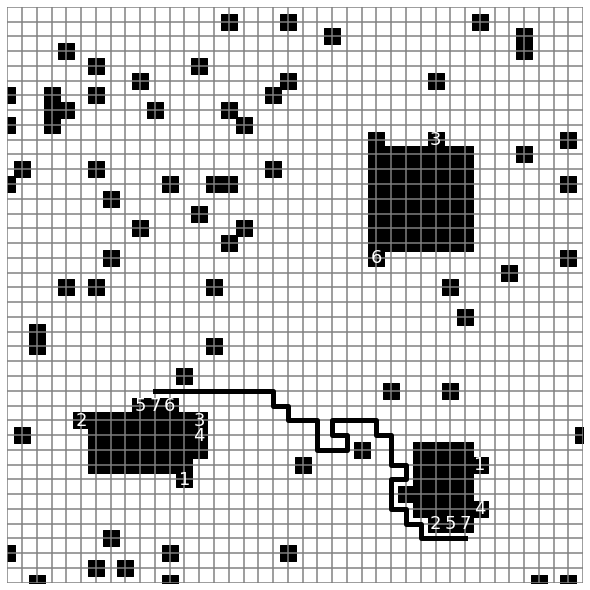

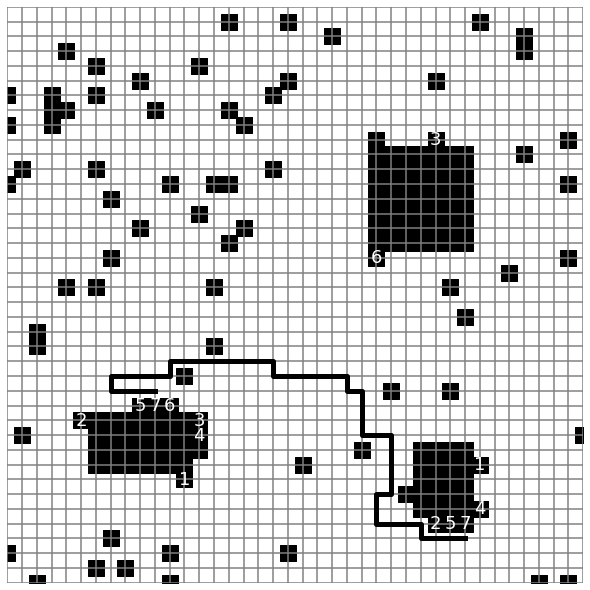

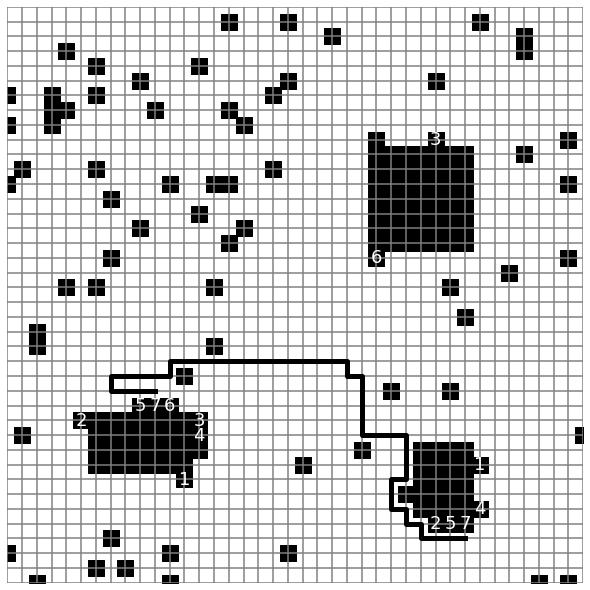

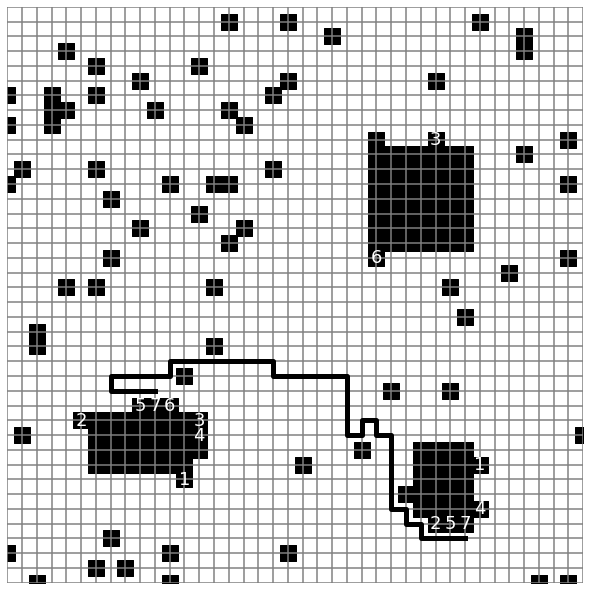

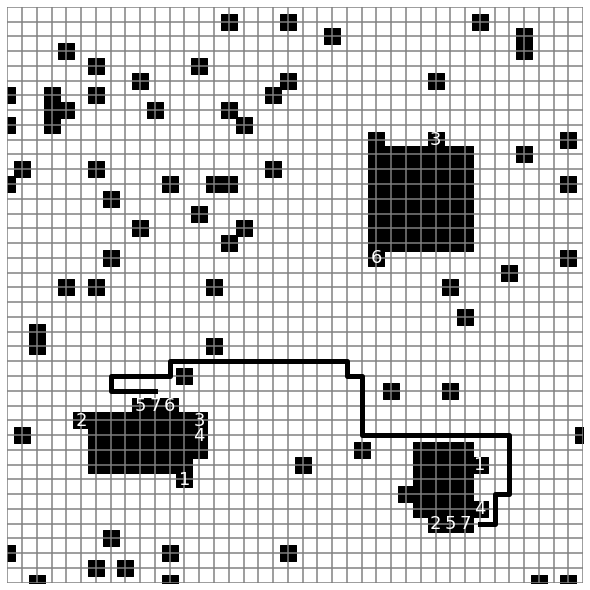

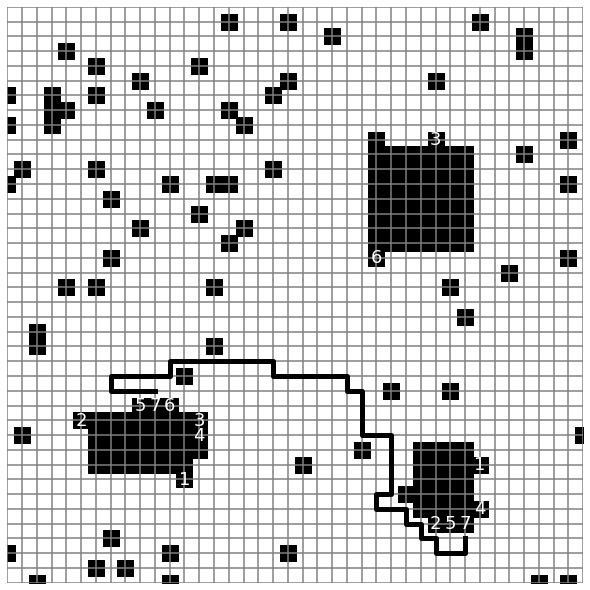

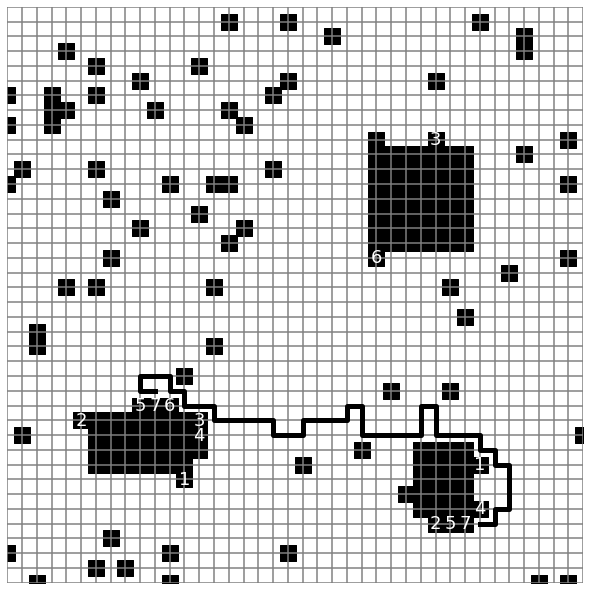

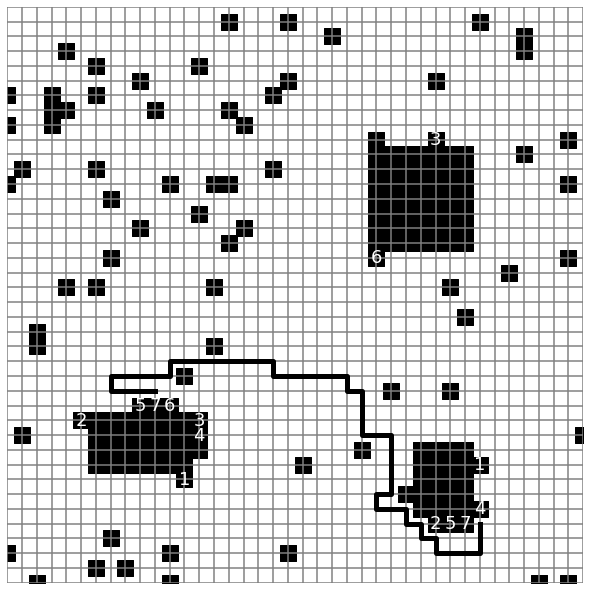

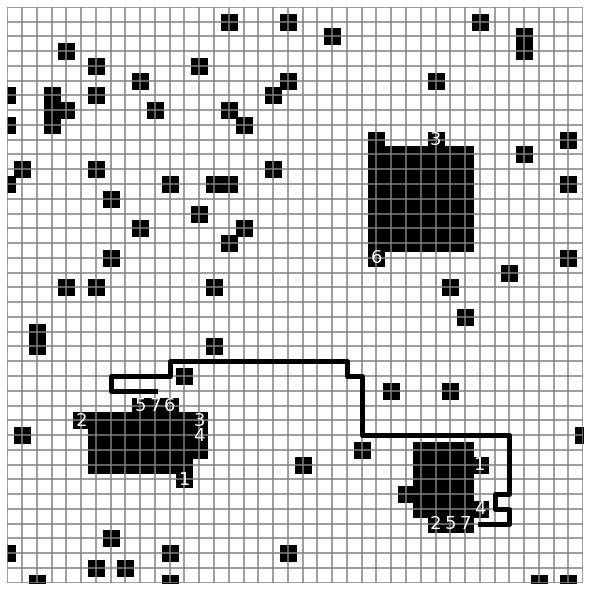

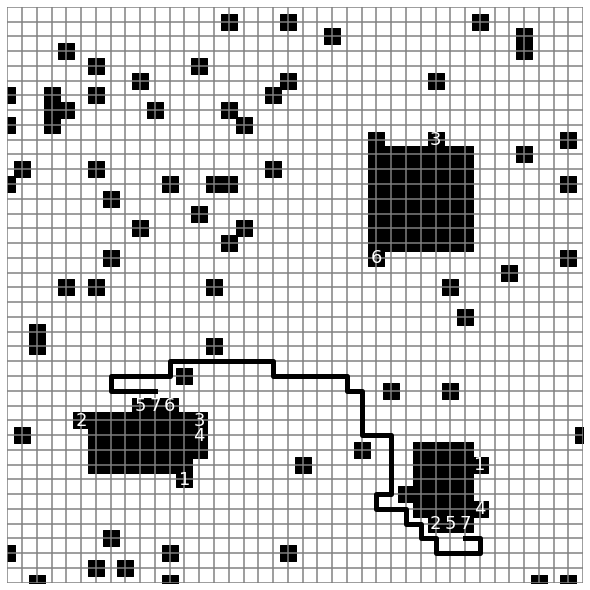

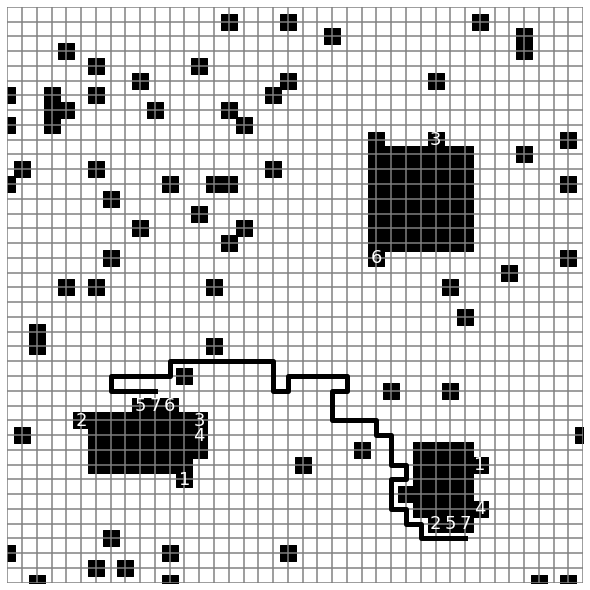

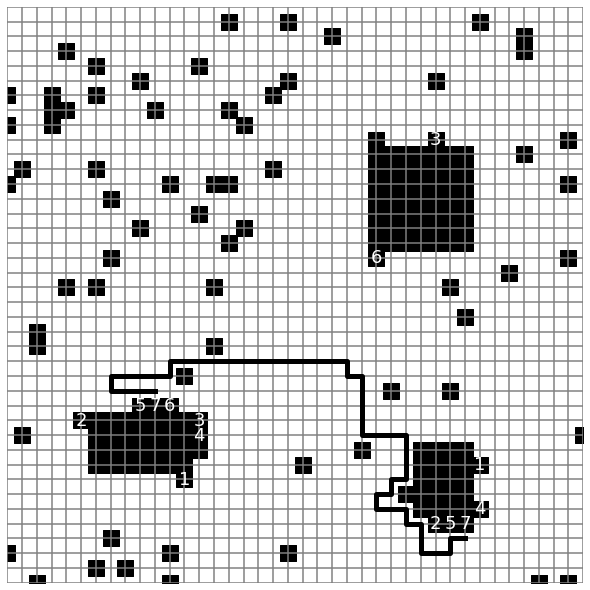

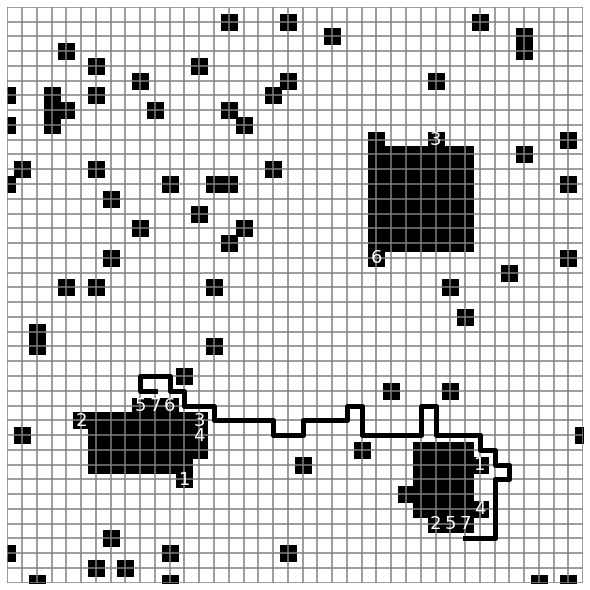

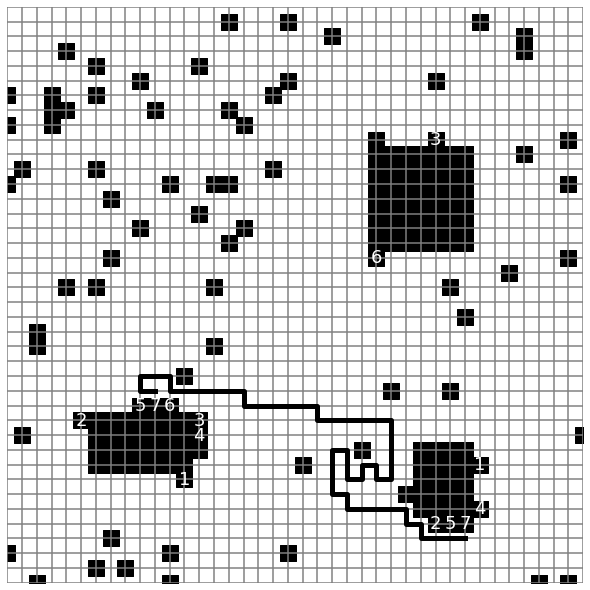

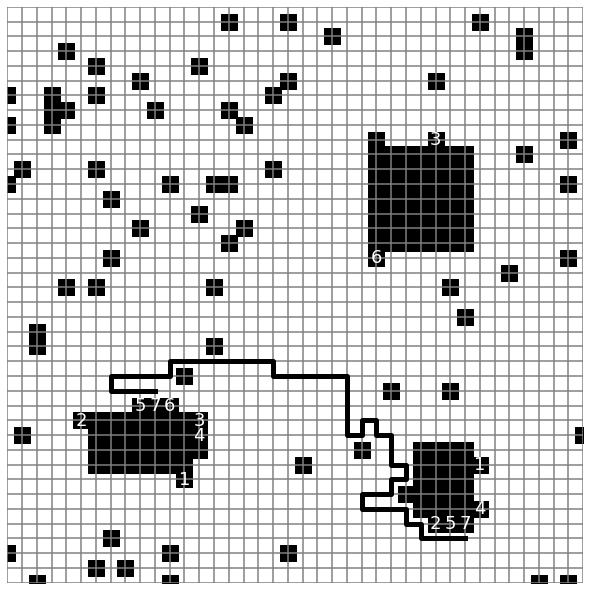

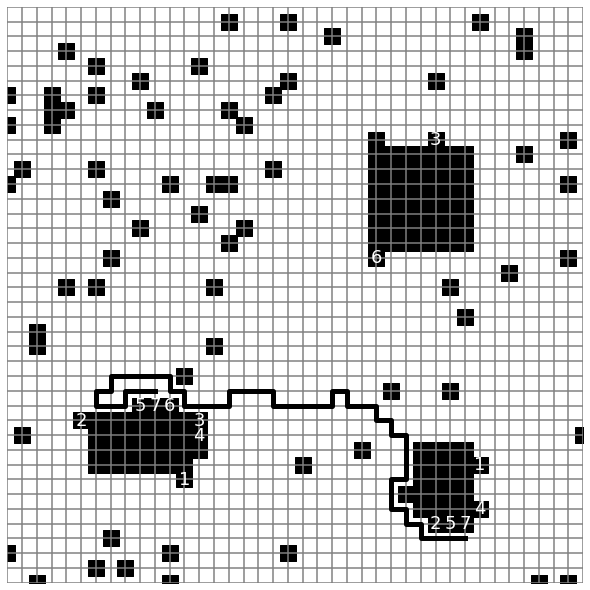

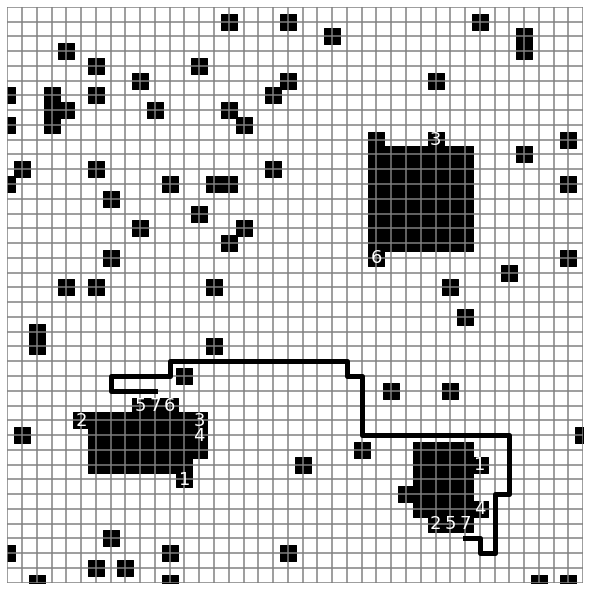

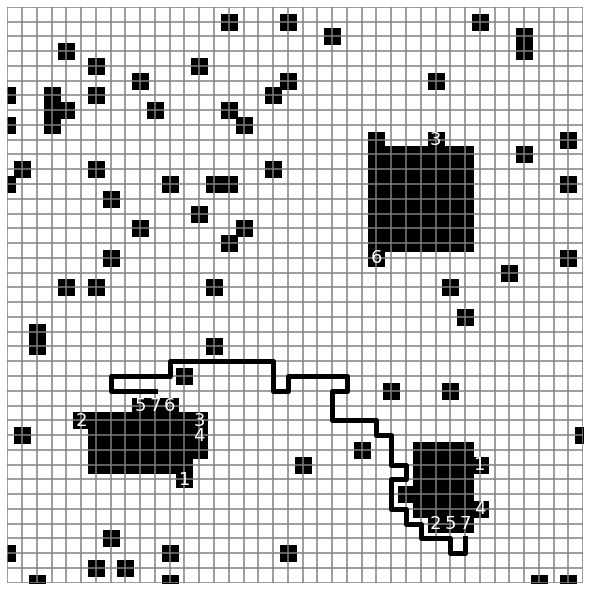

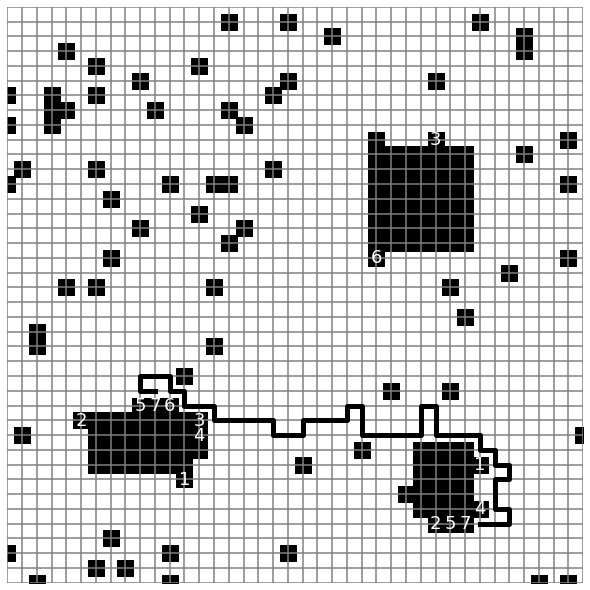

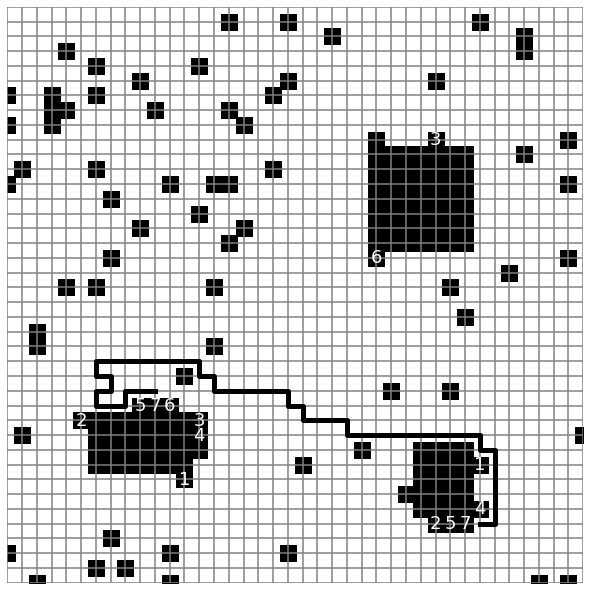

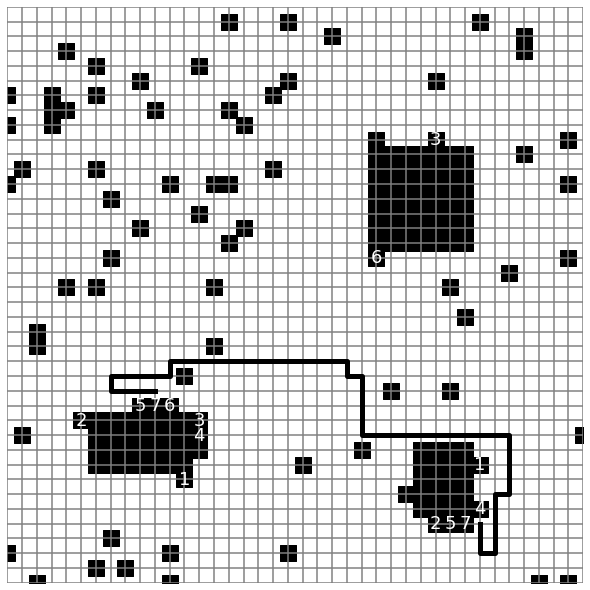

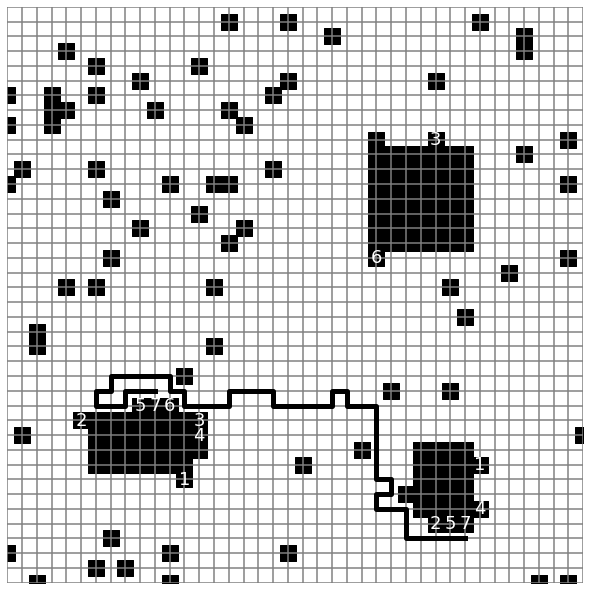

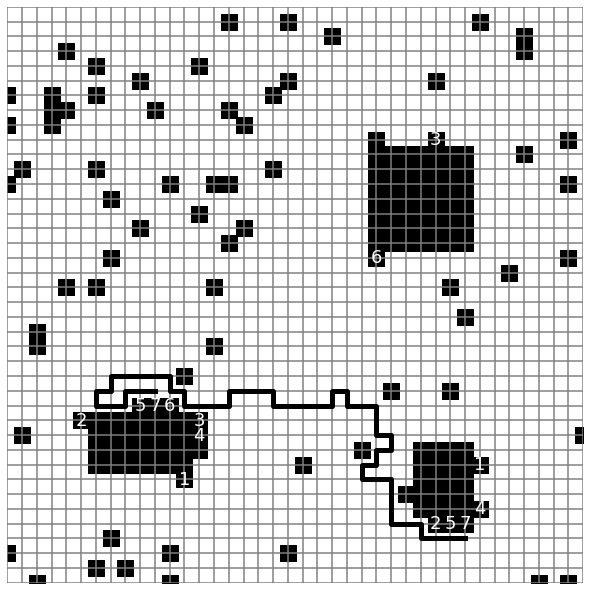

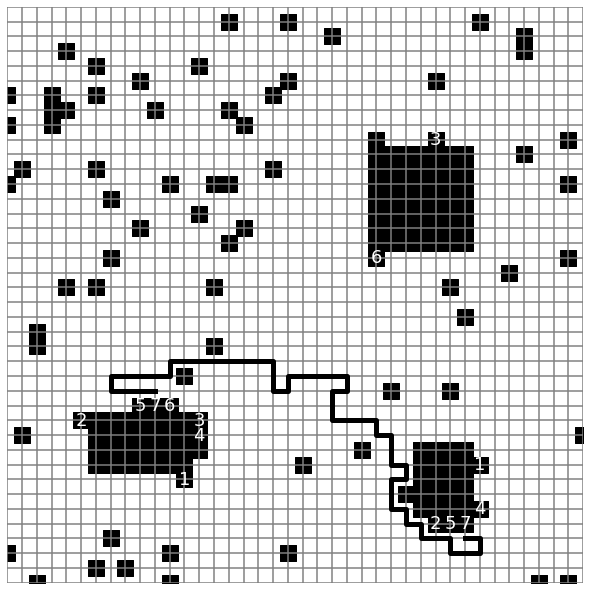

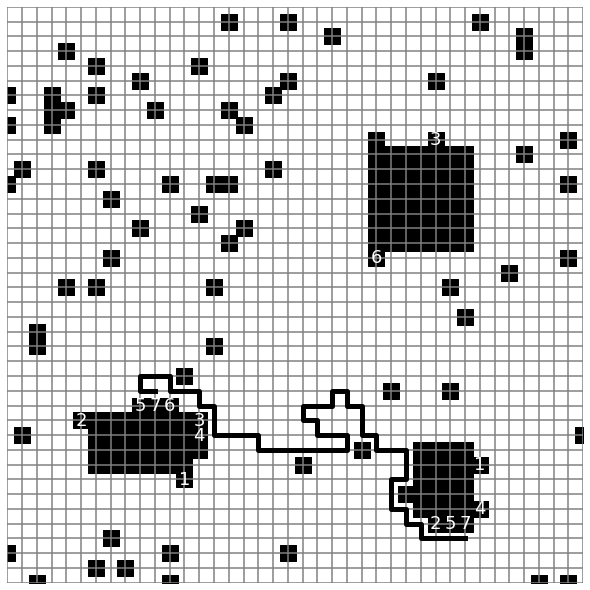

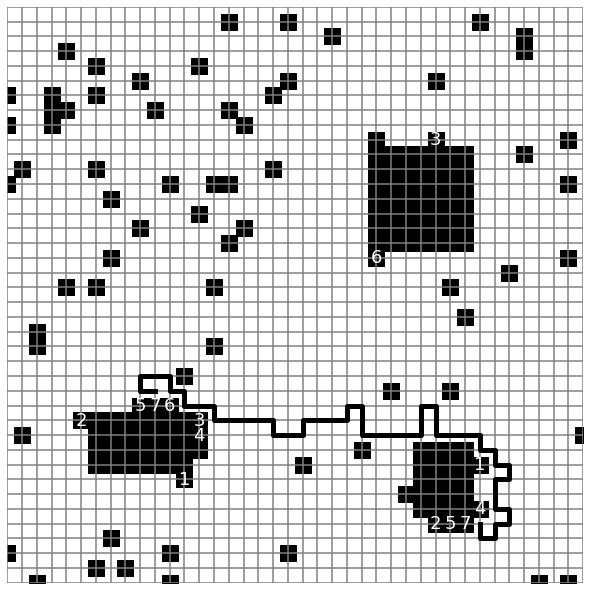

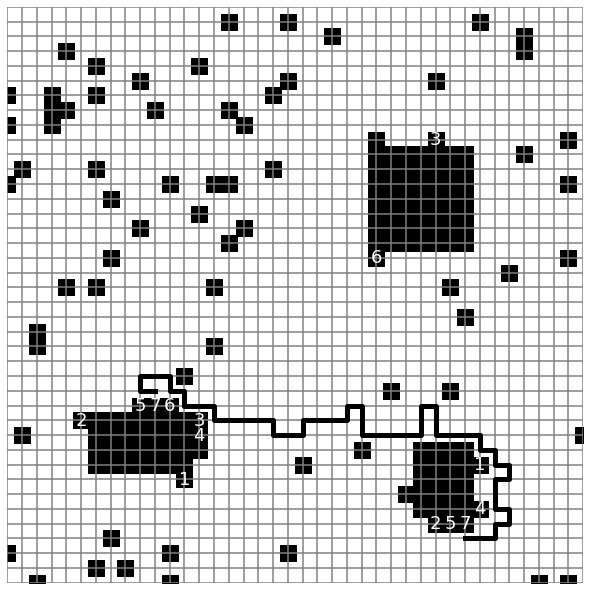

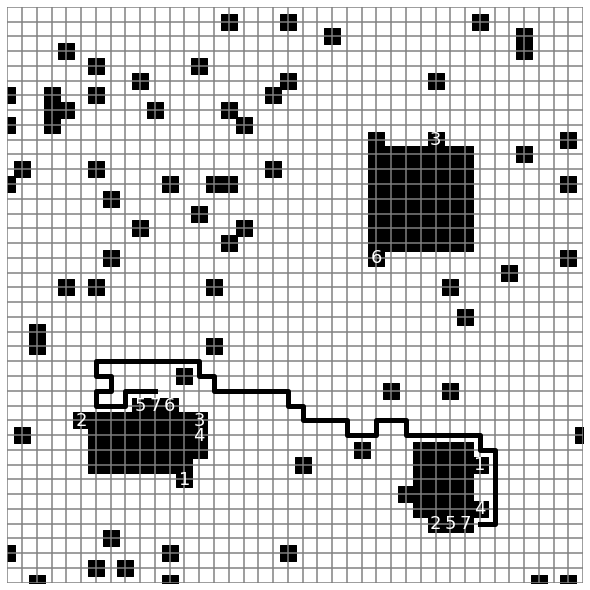

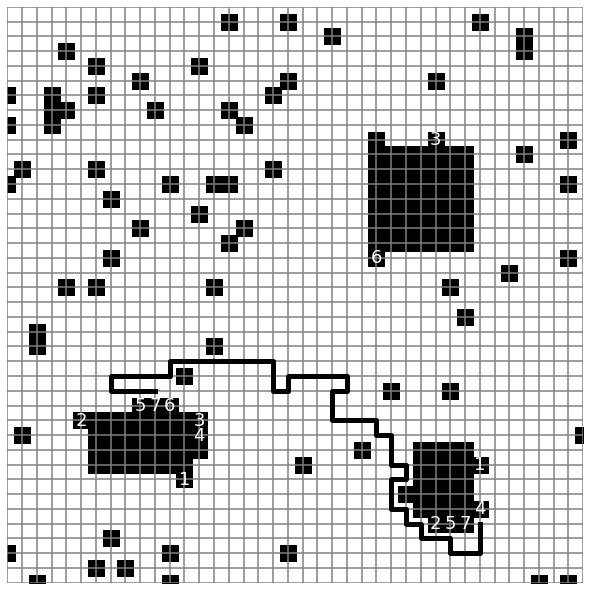

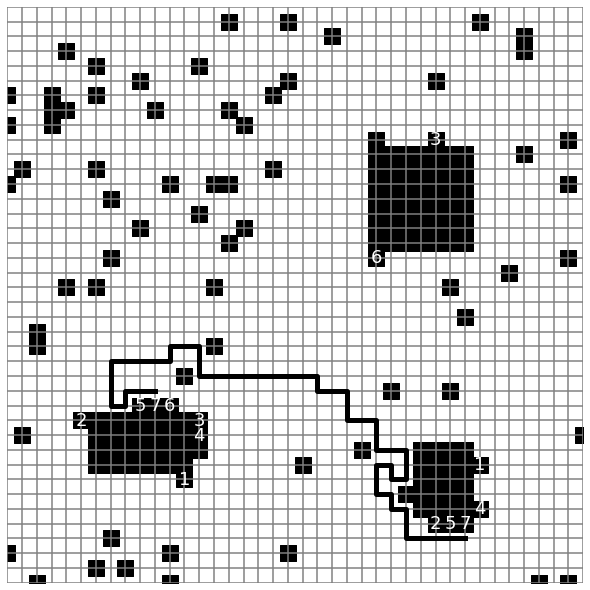

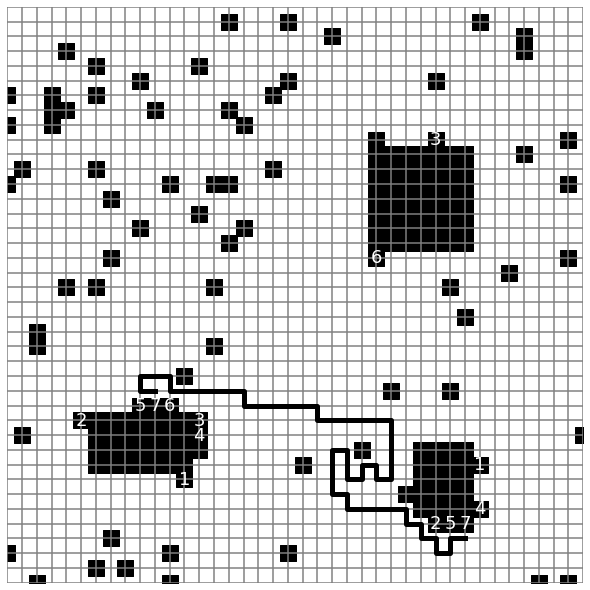

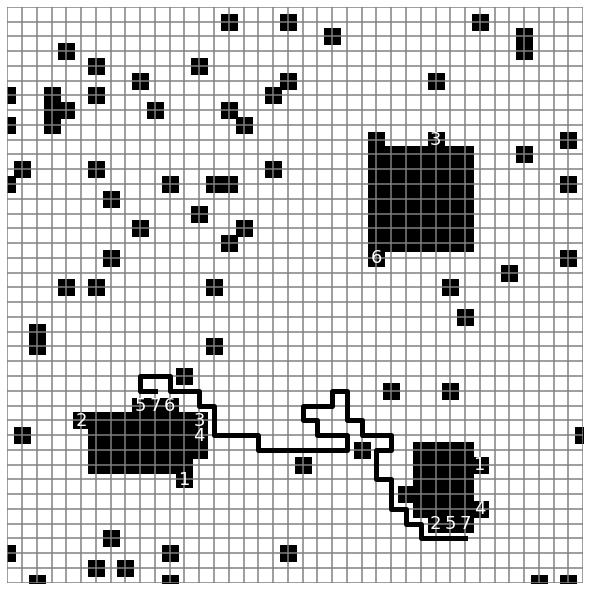

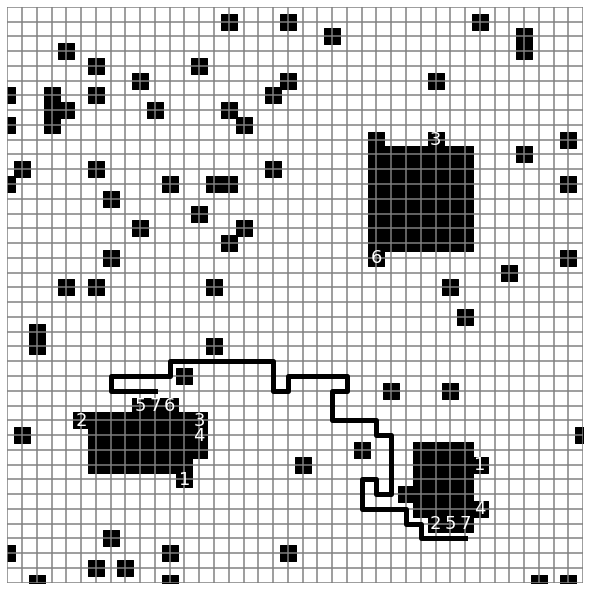

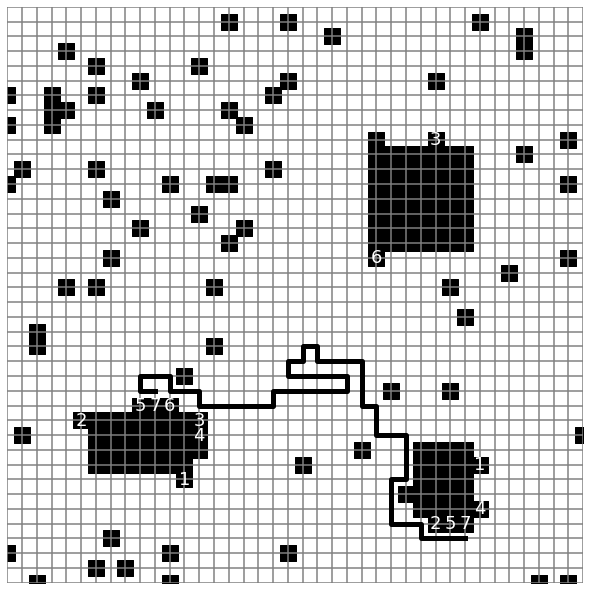

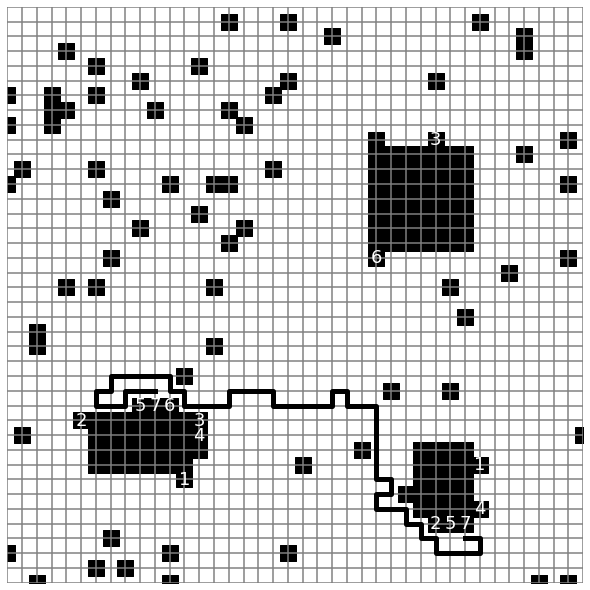

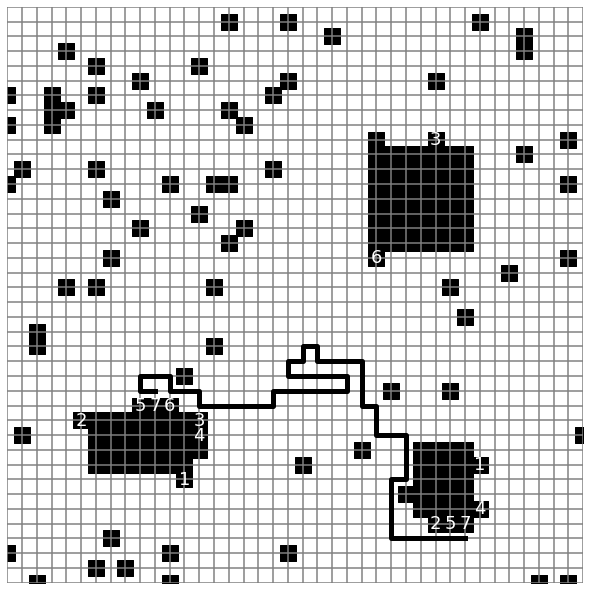

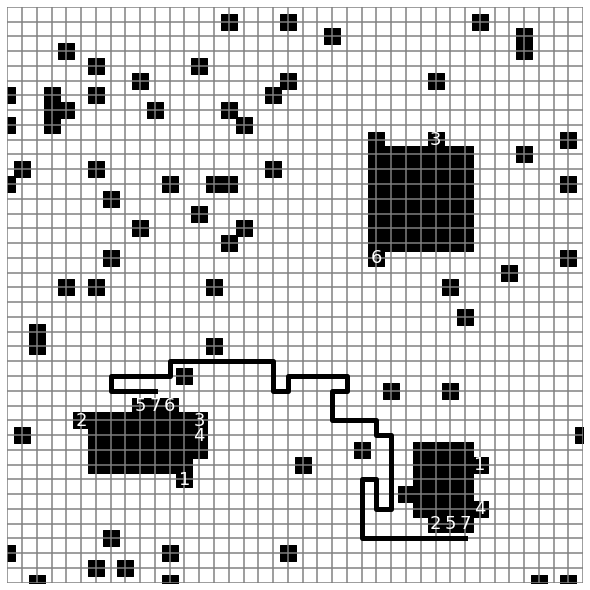

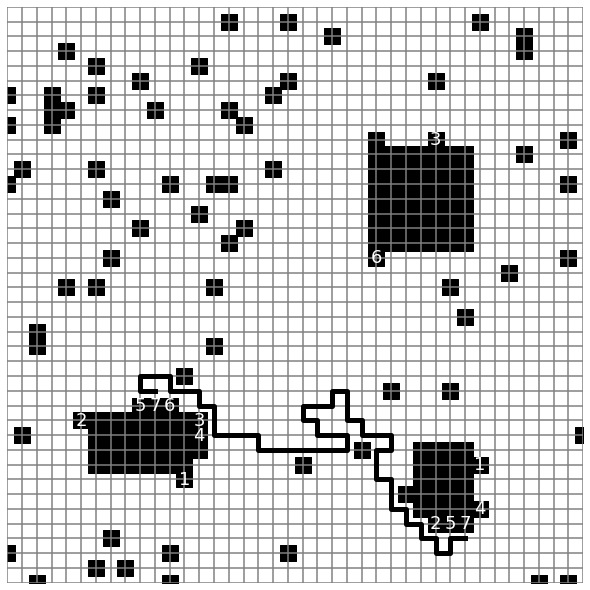

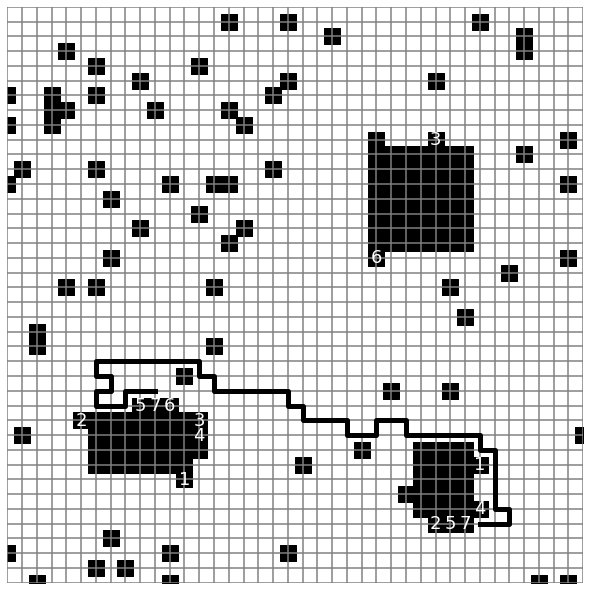

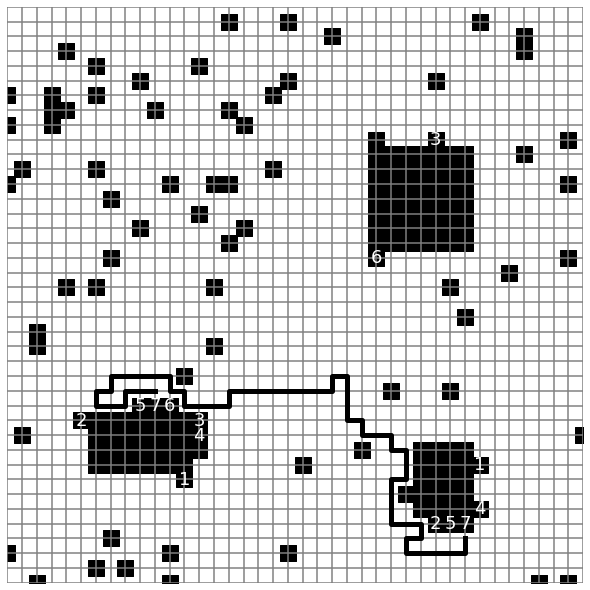

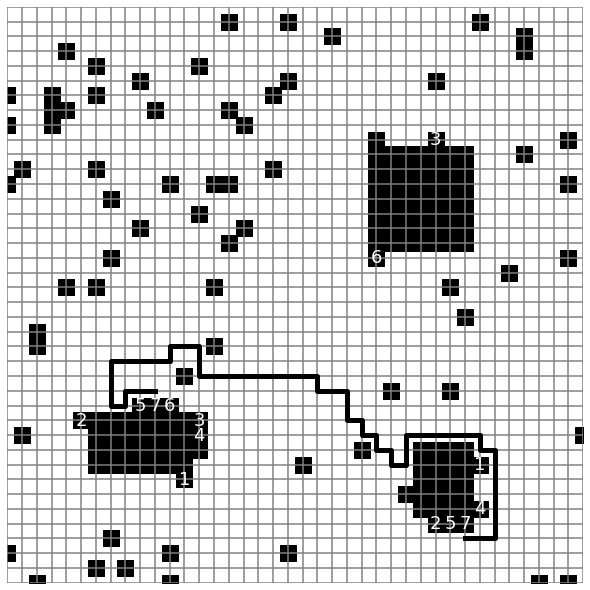

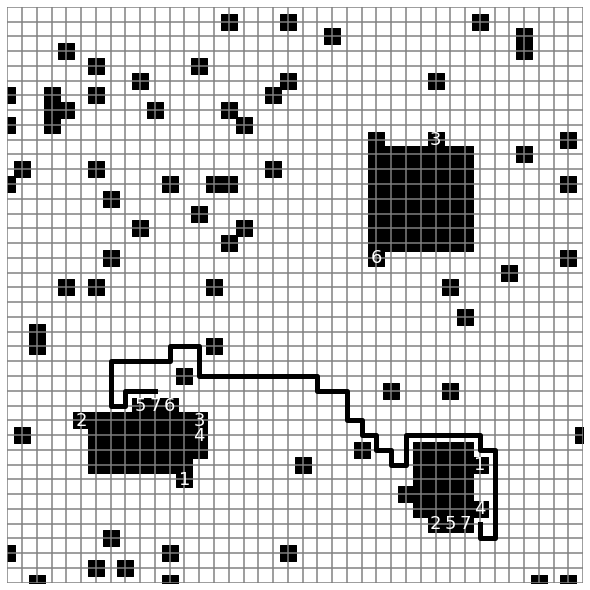

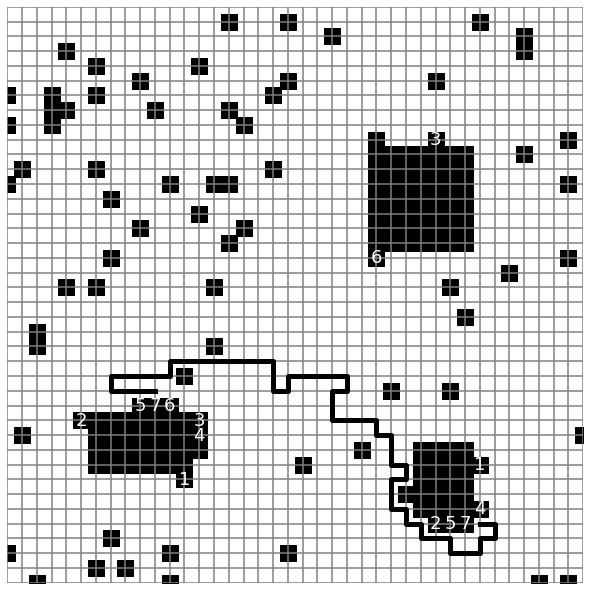

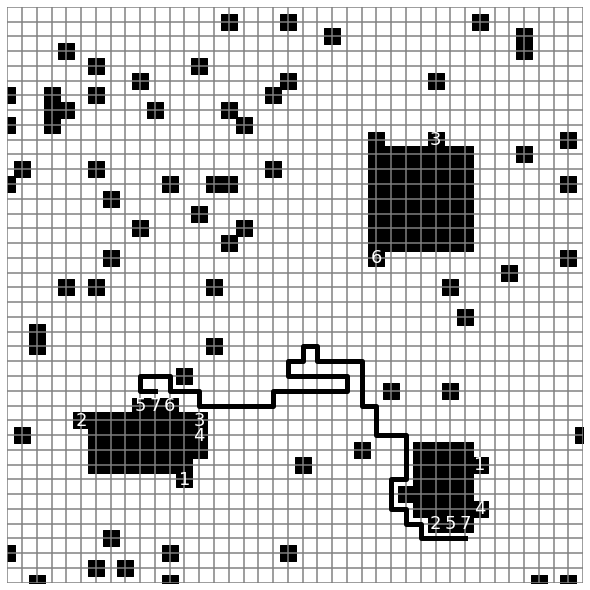

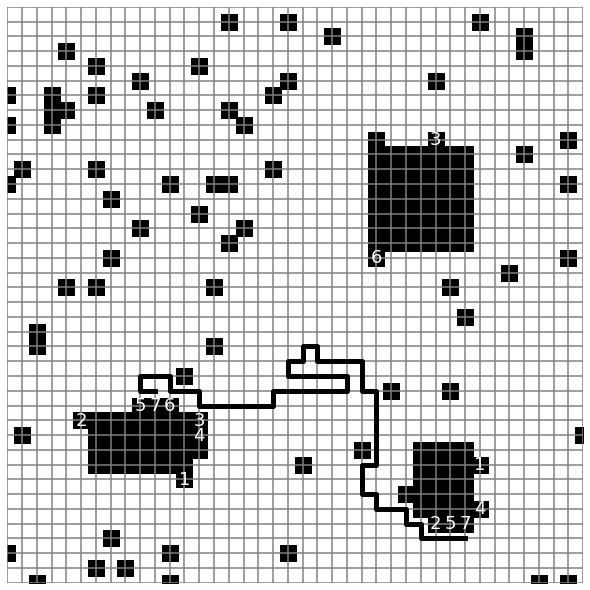

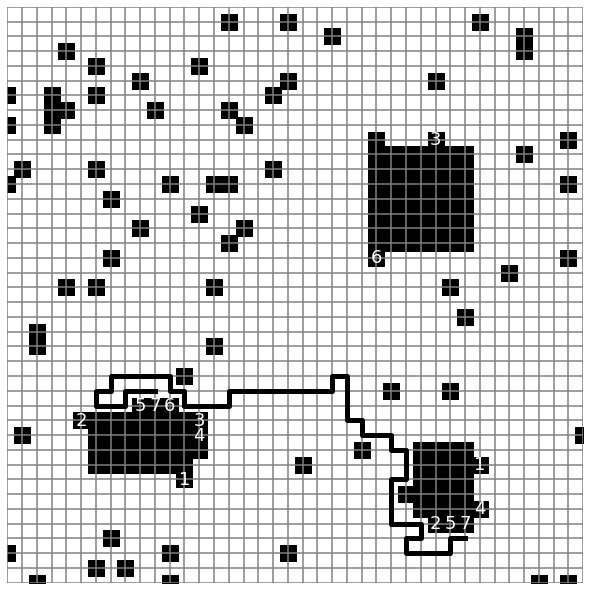

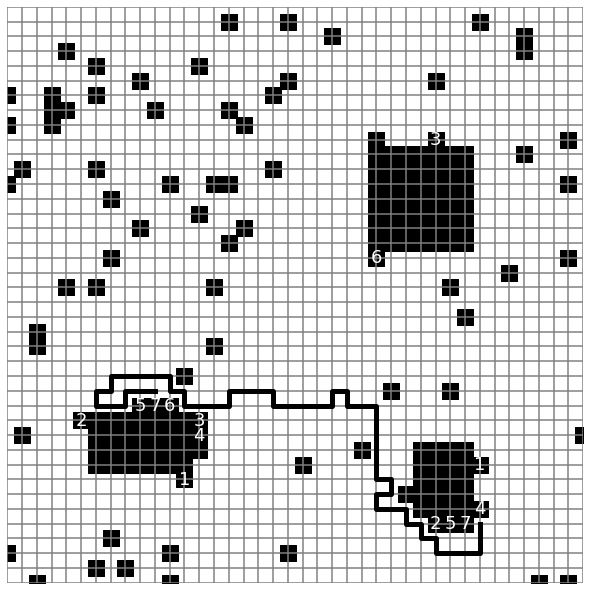

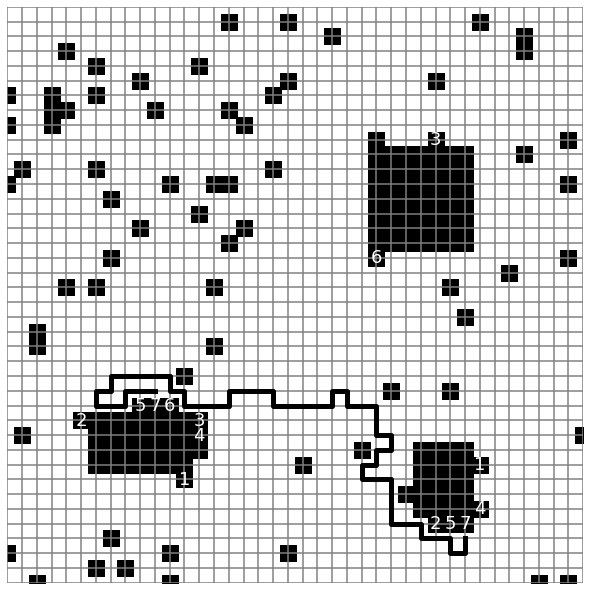

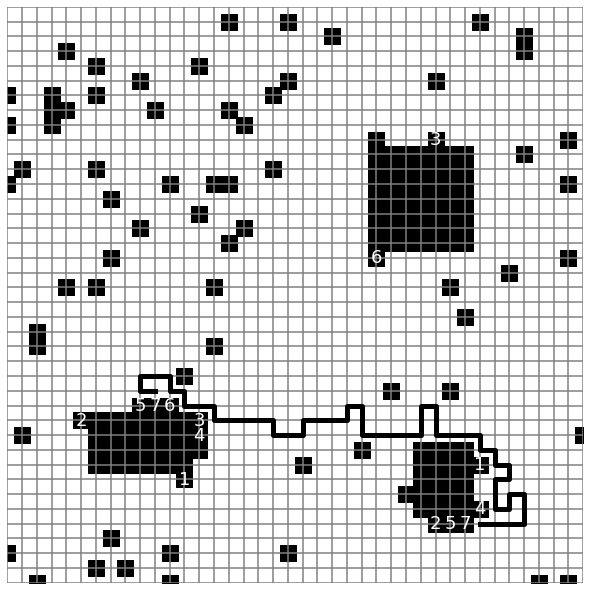

In [22]:
def draw_board(paths_x, paths_y, board, save_name):
    
    import matplotlib.pyplot as plt
    width, height = board.shape

    # create a 8" x 8" board
    fig = plt.figure(figsize=[8,8])
    # fig.patch.set_facecolor((1,1,.8))

    ax = fig.add_subplot(111)

    # draw the grid
    for x in range(40):
        ax.plot([x, x], [0,39], color=(0.5,0.5,0.5,1))
    for y in range(40):
        ax.plot([0, 39], [y,y], color=(0.5,0.5,0.5,1))

    # draw paths
    for p in range(len(paths_x)):

        ph = plt.subplot()
        ph.plot(paths_y[p], paths_x[p], linewidth=5, color='black')

    # draw obstacles
    x_axis = []
    y_axis = []
    nets = dict()
    for x in range(width):
        for y in range(height):
            if board[x, y]!=0:
                x_axis.append(y)
                y_axis.append(x)
                if board[x, y]!=1:
                    nets[(x,y)] = board[x, y]

    ax.scatter(x_axis, y_axis, marker='s', s=250, c='k')

    for xy in nets:
        ax.text(xy[1], xy[0], str(int(nets[xy])-1), fontsize=18, color='w',
                horizontalalignment='center', verticalalignment='center')

    # scale the axis area to fill the whole figure
    ax.set_position([0,0,1,1])

    # get rid of axes and everything (the figure background will show through)
    ax.set_axis_off()

    # scale the plot area conveniently (the board is in 0,0..18,18)
    ax.set_xlim(0,39)
    ax.set_ylim(0,39)
    
    fig.savefig(save_name, bbox_inches='tight')
    plt.show()


def abs_pin(board):
    for i in range(board.shape[0]):
        for j in range(board.shape[1]):
            board[i,j] = abs(board[i,j])
    return board

Bpath = "./testboard.csv"
# drawing paths
for route_idx in range(len(routes)):
    
    path = routes[route_idx]
    
    paths_x = []
    paths_y = []
    
    pathx_tem = []
    pathy_tem = []
    for i in path:
#         for i in connection:
        pathx_tem.append(i[0])
        pathy_tem.append(i[1])
    paths_x.append(pathx_tem)
    paths_y.append(pathy_tem)

    board = np.genfromtxt(Bpath, delimiter=',')
    board = abs_pin(board)
    draw_board(paths_x, paths_y, board, "./find_paths/route"+str(route_idx)+".svg")

In [18]:
for i in range(len(routes)):
    print(len(routes[i]))
print(routes[-1])

62
66
66
66
68
68
68
74
76
78
78
[(13, 10), (13, 9), (14, 9), (15, 9), (16, 9), (16, 8), (17, 8), (17, 9), (17, 10), (16, 10), (15, 10), (15, 11), (16, 11), (16, 12), (16, 13), (15, 13), (15, 14), (15, 15), (15, 16), (14, 16), (14, 17), (15, 17), (15, 18), (16, 18), (16, 19), (15, 19), (15, 20), (15, 21), (14, 21), (13, 21), (12, 21), (12, 20), (13, 20), (13, 19), (12, 19), (11, 19), (10, 19), (10, 20), (11, 20), (11, 21), (11, 22), (11, 23), (10, 23), (9, 23), (9, 22), (9, 21), (8, 21), (8, 22), (7, 22), (7, 23), (7, 24), (8, 24), (8, 25), (9, 25), (10, 25), (11, 25), (12, 25), (12, 26), (11, 26), (10, 26), (9, 26), (8, 26), (7, 26), (7, 25), (6, 25), (5, 25), (4, 25), (4, 26), (3, 26), (2, 26), (2, 27), (1, 27), (1, 28), (1, 29), (1, 30), (2, 30), (2, 31), (3, 31)]
